In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from PIL import Image

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data preprocessing

In [4]:
directory = "C:/Users/USER/Documents/data/catdog"
data_dir = pathlib.Path(directory).with_suffix('')
train_data_dir = data_dir / "training_set"
test_data_dir = data_dir / "test_set"

In [5]:
image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

25000


In [7]:
batch_size = 4
img_height = 128
img_width = 128

## Data rotation, zoom

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_ran = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255
)

In [10]:
train_ds = train_ran.flow_from_directory(train_data_dir,
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             class_mode='binary')

Found 25000 images belonging to 2 classes.


In [11]:
raw_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=5,
  image_size=(img_height, img_width))

Found 2023 files belonging to 2 classes.


## Normalization

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
val_ds = raw_ds.map(lambda x, y: (normalization_layer(x), y))

In [13]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['cat', 'dog']


## Visualization

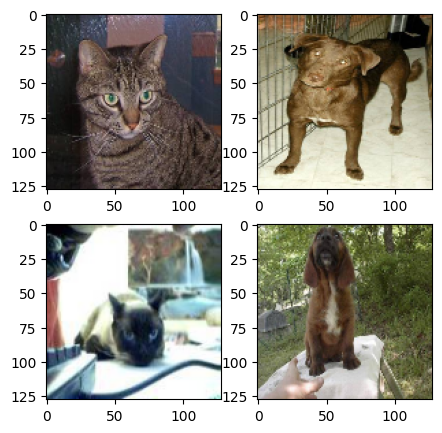

In [14]:
image1 = plt.imread(directory + '/training_set/cat/cat.1.jpg')/255
image1 = tf.image.resize(image1, [img_height,img_width])
image2 = plt.imread(directory + '/training_set/dog/dog.1.jpg')/255
image2 = tf.image.resize(image2, [img_height,img_width])
image3 = plt.imread(directory + '/training_set/cat/cat.5.jpg')/255
image3 = tf.image.resize(image3, [img_height,img_width])
image4 = plt.imread(directory + '/training_set/dog/dog.5.jpg')/255
image4 = tf.image.resize(image4, [img_height,img_width])
fig, ax = plt.subplots(2,2, figsize=(5,5))
ax[0,0].imshow(image1)
ax[0,1].imshow(image2)
ax[1,0].imshow(image3)
ax[1,1].imshow(image4)

# Model

In [15]:
def mapping(input):
    if np.argmax(input) == 0:
        return "cat"
    else:
        return "dog"

## LeNet

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = 'best_model2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [15]:
parameters = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
]

In [16]:
tf.debugging.set_log_device_placement(True)
model = tf.keras.Sequential(parameters)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/20
6248/6250 [============================>.] - ETA: 0s - loss: 0.6947 - accuracy: 0.5077

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 164s 20ms/step - loss: 0.6947 - accuracy: 0.5076 - val_loss: 0.6865 - val_accuracy: 0.5433
Epoch 2/20
6248/6250 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.5917

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 106s 17ms/step - loss: 0.6671 - accuracy: 0.5918 - val_loss: 0.6233 - val_accuracy: 0.6678
Epoch 3/20
6249/6250 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.6508

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 106s 17ms/step - loss: 0.6299 - accuracy: 0.6508 - val_loss: 0.6122 - val_accuracy: 0.6807
Epoch 4/20
6248/6250 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.6753

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 105s 17ms/step - loss: 0.5998 - accuracy: 0.6752 - val_loss: 0.5578 - val_accuracy: 0.7331
Epoch 5/20
6250/6250 [==============================] - 118s 19ms/step - loss: 0.5811 - accuracy: 0.6968 - val_loss: 0.5796 - val_accuracy: 0.7034
Epoch 6/20
6249/6250 [============================>.] - ETA: 0s - loss: 0.5552 - accuracy: 0.7158

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 128s 21ms/step - loss: 0.5551 - accuracy: 0.7158 - val_loss: 0.5093 - val_accuracy: 0.7598
Epoch 7/20
6250/6250 [==============================] - 109s 17ms/step - loss: 0.5419 - accuracy: 0.7303 - val_loss: 0.5114 - val_accuracy: 0.7637
Epoch 8/20
6247/6250 [============================>.] - ETA: 0s - loss: 0.5294 - accuracy: 0.7379

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 109s 17ms/step - loss: 0.5295 - accuracy: 0.7378 - val_loss: 0.4840 - val_accuracy: 0.7771
Epoch 9/20
6247/6250 [============================>.] - ETA: 0s - loss: 0.5157 - accuracy: 0.7516

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 105s 17ms/step - loss: 0.5157 - accuracy: 0.7516 - val_loss: 0.4490 - val_accuracy: 0.7944
Epoch 10/20
6250/6250 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.7640

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 108s 17ms/step - loss: 0.4987 - accuracy: 0.7640 - val_loss: 0.4440 - val_accuracy: 0.7983
Epoch 11/20
6248/6250 [============================>.] - ETA: 0s - loss: 0.4886 - accuracy: 0.7728

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 110s 18ms/step - loss: 0.4885 - accuracy: 0.7728 - val_loss: 0.4328 - val_accuracy: 0.7963
Epoch 12/20
6249/6250 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.7772

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 118s 19ms/step - loss: 0.4780 - accuracy: 0.7772 - val_loss: 0.4218 - val_accuracy: 0.8186
Epoch 13/20
6248/6250 [============================>.] - ETA: 0s - loss: 0.4660 - accuracy: 0.7879

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 113s 18ms/step - loss: 0.4662 - accuracy: 0.7878 - val_loss: 0.4158 - val_accuracy: 0.8171
Epoch 14/20
6250/6250 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.7892

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 117s 19ms/step - loss: 0.4609 - accuracy: 0.7892 - val_loss: 0.4021 - val_accuracy: 0.8250
Epoch 15/20
6250/6250 [==============================] - 111s 18ms/step - loss: 0.4532 - accuracy: 0.7903 - val_loss: 0.4228 - val_accuracy: 0.8230
Epoch 16/20
6248/6250 [============================>.] - ETA: 0s - loss: 0.4445 - accuracy: 0.8000

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 113s 18ms/step - loss: 0.4444 - accuracy: 0.8000 - val_loss: 0.4003 - val_accuracy: 0.8176
Epoch 17/20
6248/6250 [============================>.] - ETA: 0s - loss: 0.4443 - accuracy: 0.7986

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


6250/6250 [==============================] - 114s 18ms/step - loss: 0.4443 - accuracy: 0.7986 - val_loss: 0.3729 - val_accuracy: 0.8369
Epoch 18/20
6250/6250 [==============================] - 115s 18ms/step - loss: 0.4394 - accuracy: 0.8022 - val_loss: 0.3798 - val_accuracy: 0.8285
Epoch 19/20
6250/6250 [==============================] - 119s 19ms/step - loss: 0.4328 - accuracy: 0.8039 - val_loss: 0.3855 - val_accuracy: 0.8275
Epoch 20/20
6250/6250 [==============================] - 152s 24ms/step - loss: 0.4338 - accuracy: 0.8066 - val_loss: 0.3782 - val_accuracy: 0.8398


In [17]:
results = model.evaluate(val_ds, verbose=0)
print(results)

[0.37294986844062805, 0.8368759155273438]


In [18]:
model.save("bestModel.h5")

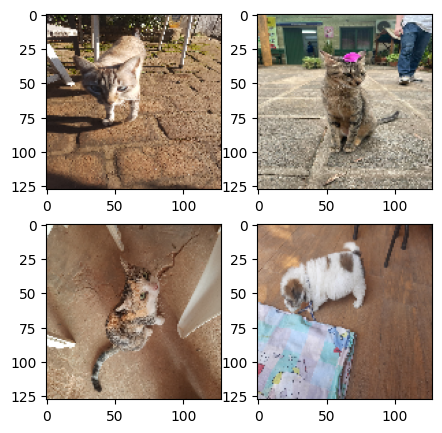

In [19]:
image1 = plt.imread('cat.jpg')/255
image1 = tf.image.resize(image1, [img_height,img_width])
image1 = tf.image.rot90(image1, k=3)
image2 = plt.imread('cat2.jpeg')/255
image2 = tf.image.resize(image2, [img_height,img_width])
image3 = plt.imread('cat3.jpg')/255
image3 = tf.image.resize(image3, [img_height,img_width])
image4 = plt.imread('dog.jpg')/255
image4 = tf.image.resize(image4, [img_height,img_width])
fig, ax = plt.subplots(2,2, figsize=(5,5))
ax[0,0].imshow(image1)
ax[0,1].imshow(image2)
ax[1,0].imshow(image3)
ax[1,1].imshow(image4)

In [20]:
mapping(model.predict(image1[tf.newaxis,...]))

1/1 [==============================] - 1s 903ms/step


'cat'

In [21]:
mapping(model.predict(image2[tf.newaxis,...]))

1/1 [==============================] - 0s 19ms/step


'dog'

In [22]:
mapping(model.predict(image3[tf.newaxis,...]))

1/1 [==============================] - 0s 20ms/step


'dog'

In [23]:
mapping(model.predict(image4[tf.newaxis,...]))

1/1 [==============================] - 0s 20ms/step


'dog'

In [24]:
image_batch, labels_batch = next(iter(val_ds))

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = np.argmax(model.predict(image_batch), axis=1)
cm = confusion_matrix(labels_batch, predictions)
clr = classification_report(labels_batch, predictions, zero_division=0)
print(clr)

1/1 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       1.00      0.69      0.81        16

    accuracy                           0.84        32
   macro avg       0.88      0.84      0.84        32
weighted avg       0.88      0.84      0.84        32



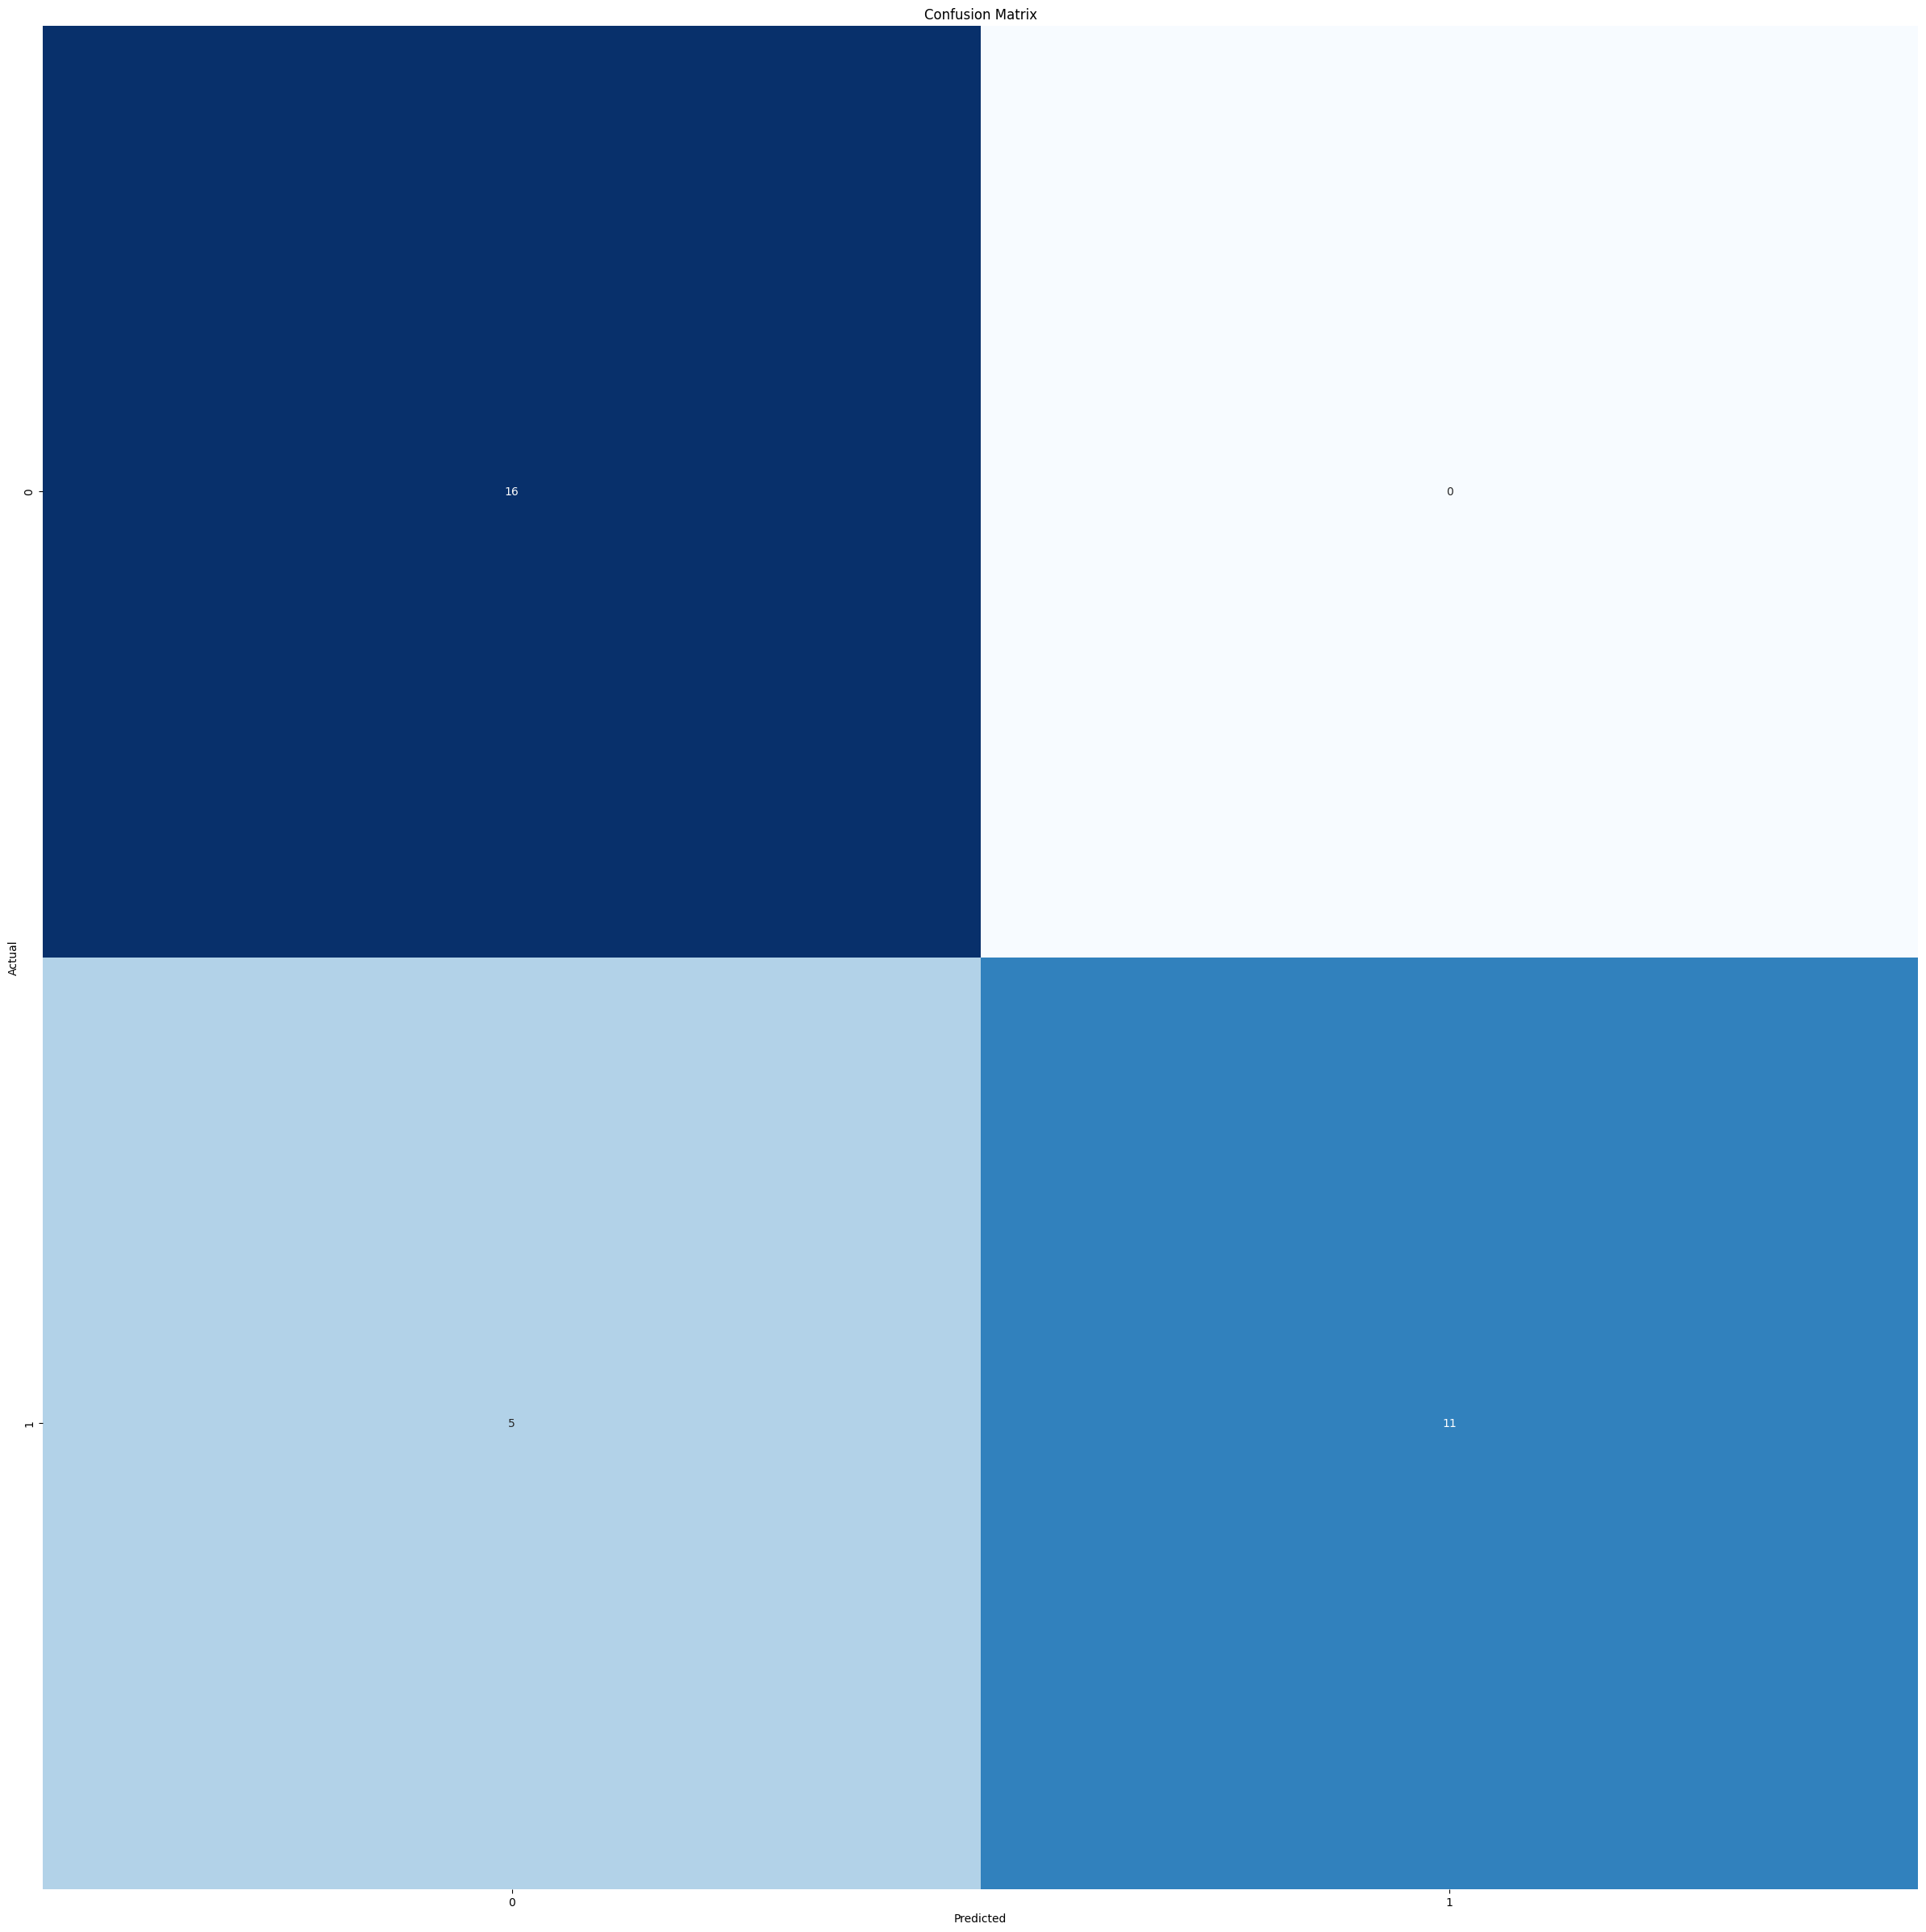

In [26]:
import seaborn as sns
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## AlexNet

In [17]:
parameters = [
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), activation='relu', padding="same", input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
]

In [18]:
alexNet = tf.keras.Sequential(parameters)
alexNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    alexNet.fit(train_ds, epochs=20, validation_data=val_ds, batch_size=2, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/20
1447/6250 [=====>........................] - ETA: 20:14 - loss: 0.7398 - accuracy: 0.4900


KeyboardInterrupt



AlexNet, indeed, took over two weeks to train...